In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
from sklearn.utils import shuffle
from math import ceil
import matplotlib.pyplot as plt
import cv2
import imageio.v2 as iio
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, classification_report
from tqdm import tqdm


In [2]:
# List all available devices
devices = tf.config.list_physical_devices()

# Check if GPU is available
gpu_devices = [device for device in devices if device.device_type == 'GPU']

# If GPU is available, use the first GPU, otherwise fallback to CPU
if gpu_devices:
    print("Using GPU:", gpu_devices[0])
    tf.config.set_visible_devices(gpu_devices[0], 'GPU')
else:
    cpu_devices = [device for device in devices if device.device_type == 'CPU']
    print("Using CPU:", cpu_devices[0])
    tf.config.set_visible_devices(cpu_devices[0], 'CPU')

SEED = 3
tf.random.set_seed(SEED)

Using GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


# Transfer Learning for Video Classification

Videos can be viewed as a sequences of individual images; therefore, one can deal
with video classification as performing image classification L times, where L is
the number of frames in a video. However, this setting has a problem: it does
not capture the temporal nature of the video. That is why we use RNN-CNN for
video classification. Training RNN-CNN’s needs a lot of computational resources,
and it might sometimes be excessive, so in this project we will take a simpler
approach.

In this approach, we train a CNN for image classification, and turn it into a video
classifier using moving averages. If we rely on only one or a few frames of a
video for classifying it, we will observe a phenomenon called flickering, which is
assigning different labels to different frames of a video in the same class. However,
if we use an average of predictions of probabilities for multiple frames, we will get
a more reliable prediction for a video.

## Data Exploration and Pre-processing

### Load images from each class folder and divide into train, validation, and test datasets

In [4]:
# Gather Image paths
img_classes = ['baseball', 'basketball', 'fencing', 'tennis', 'volleyball']
img_train, img_val, img_test = [], [], []

for c in img_classes:
    img = []
    for dir,_,files in os.walk(f"../Data/Sport Images/{c}"):
        for file in files:
            img.append([os.path.join(dir, file), c])
    img = shuffle(img, random_state=SEED)
    img_train += img[:ceil(0.7*len(img))]
    img_val += img[ceil(0.7*len(img)):ceil(0.85*len(img))]
    img_test += img[ceil(0.85*len(img)):]

img_complete = img_train + img_val + img_test
len(img_complete)

3280

### Loading images into TensorFlow dataset and Resizing to (224, 224)

In [4]:
# load Image dataset
train_ds = tf.data.Dataset.from_tensor_slices(([i[0] for i in img_train], [i[1] for i in img_train]))
val_ds = tf.data.Dataset.from_tensor_slices(([i[0] for i in img_val], [i[1] for i in img_val]))
test_ds = tf.data.Dataset.from_tensor_slices(([i[0] for i in img_test], [i[1] for i in img_test]))
complete_ds = tf.data.Dataset.from_tensor_slices(([i[0] for i in img_complete], [i[1] for i in img_complete]))
IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)

# Function to load and preprocess images
def load_and_preprocess_image(path, label):
    def _load_and_preprocess(path, label):
        # Read the image using ImageIO (Supports all the extensions required)
        img = iio.imread(path.numpy().decode('utf-8'))
        # Resize the image
        img = cv2.resize(img, IMG_SIZE)
        # Cast to float
        image = tf.cast(img, tf.float32)
        label = img_classes.index(label)
        return image, label
    return tf.py_function(_load_and_preprocess, [path, label], [tf.float32, tf.int64])

# Create the final dataset by applying the load_and_preprocess_image function
train_dataset = train_ds.map(load_and_preprocess_image)
val_dataset = val_ds.map(load_and_preprocess_image)
test_dataset = test_ds.map(load_and_preprocess_image)
complete_dataset = complete_ds.map(load_and_preprocess_image)

# Shuffle the dataset
buffer_size = len(img_train)  # You can adjust the buffer size as needed
train_dataset = train_dataset.cache().shuffle(buffer_size, seed=SEED)
buffer_size = len(img_val)  # You can adjust the buffer size as needed
val_dataset = val_dataset.cache().shuffle(buffer_size, seed=SEED).prefetch(buffer_size=tf.data.AUTOTUNE)
buffer_size = len(img_test)  # You can adjust the buffer size as needed
test_dataset = test_dataset.cache().shuffle(buffer_size, seed=SEED).prefetch(buffer_size=tf.data.AUTOTUNE)
buffer_size = len(img_complete)  # You can adjust the buffer size as needed
complete_dataset = complete_dataset.cache().shuffle(buffer_size, seed=SEED)

# batch size for dataset
BATCH_SIZE = 64 
# IMPORTANT : I did not keep the batch size at 5, because the training hangs in the middle and does not complete
# for smaller batch sizes. I observed this behavior with other people training their model on M1 mac systems.
train_dataset = train_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)
complete_dataset = complete_dataset.batch(BATCH_SIZE)

# Set the shapes explicitly
train_dataset = train_dataset.map(lambda x, y: (tf.ensure_shape(x, (None, *IMG_SHAPE)), tf.ensure_shape(y, (None,))))
val_dataset = val_dataset.map(lambda x, y: (tf.ensure_shape(x, (None, *IMG_SHAPE)), tf.ensure_shape(y, (None,))))
test_dataset = test_dataset.map(lambda x, y: (tf.ensure_shape(x, (None, *IMG_SHAPE)), tf.ensure_shape(y, (None,))))
complete_dataset = complete_dataset.map(lambda x, y: (tf.ensure_shape(x, (None, *IMG_SHAPE)), tf.ensure_shape(y, (None,))))

Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2023-05-09 11:15:32.166452: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


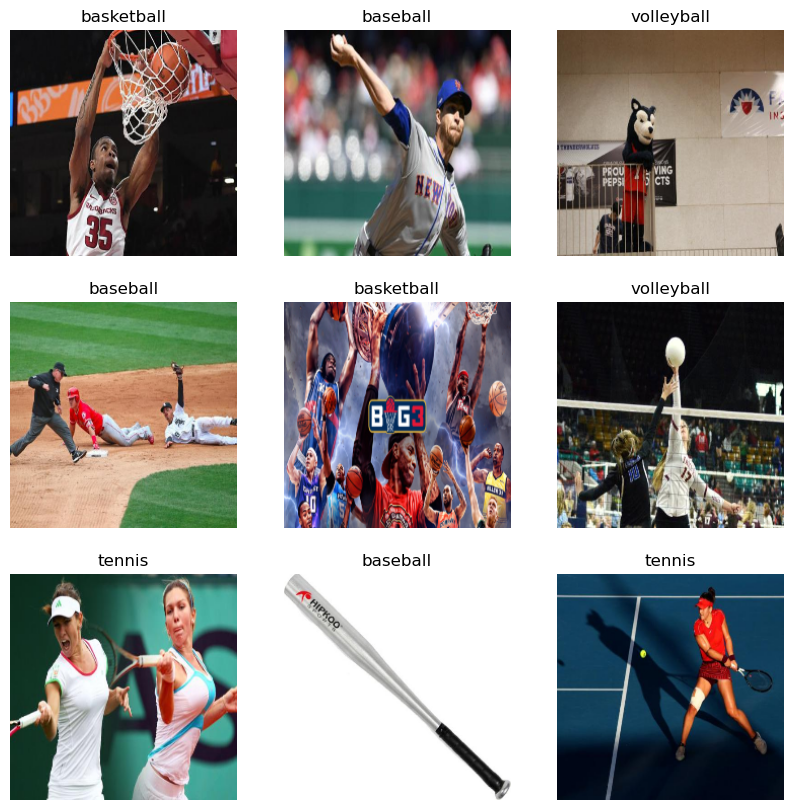

In [5]:
# Visualize sample images from train dataset
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy() / 255)
        plt.title(img_classes[labels[i].numpy()])
        plt.axis("off")
plt.show()

## Transfer Learning for Image Classification

### Model Architecture

In [6]:
class Classification_Model(tf.keras.Model):

    def __init__(self, numClasses, seed=SEED, base='RESNET'):
        super().__init__()
        # loading the base model and preprocessing layers
        self.preprocess = None
        self.base = None
        if base=='RESNET':
            self.preprocess = tf.keras.applications.resnet50.preprocess_input
            self.base = tf.keras.applications.resnet50.ResNet50(input_shape=IMG_SHAPE,
                                                       include_top=False,
                                                       weights='imagenet')
        elif base=='EFFICIENTNET':
            self.preprocess = tf.keras.applications.efficientnet.preprocess_input
            self.base = tf.keras.applications.efficientnet.EfficientNetB0(input_shape=IMG_SHAPE,
                                                           include_top=False,
                                                           weights='imagenet')
        elif base=='VGGNET':
            self.preprocess = tf.keras.applications.vgg16.preprocess_input
            self.base = tf.keras.applications.vgg16.VGG16(input_shape=IMG_SHAPE,
                                                       include_top=False,
                                                       weights='imagenet')
        else:
            raise TypeError("Base model not supported")
        # freezing the base model parameters
        self.base.trainable = False
        # layer to flatten the base model output
        self.flatten = tf.keras.layers.Flatten()
        # drop out layer
        self.drop = tf.keras.layers.Dropout(0.2)
        # batch normalization layer
        self.batchNorm = tf.keras.layers.BatchNormalization()
        # fully connected layers
        self.dense1 = tf.keras.layers.Dense(512, activation='relu')
        self.dense2 = tf.keras.layers.Dense(numClasses, activation='softmax')
        

    def call(self, inputs):
        # preprocess the input
        x = self.preprocess(inputs)
        # feature extraction using the base model
        x = self.base(x)
        # flatten the features to 1-D array
        x = self.flatten(x)
        # 1st fully connected layer with RELU
        x = self.dense1(x)
        # batch normalization for training stability
        x = self.batchNorm(x)
        # regularization in the form of dropout layer
        x = self.drop(x)
        # 2nd fully connected layer for the output classes with SOFTMAX
        out = self.dense2(x)
        return out
    
    

### Image Augmentation (Empirical regularization)

In [7]:
# Create a function to apply the data augmentation pipeline to a batch of images
def augment_images(images):
    # Define the data augmentation pipeline
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomCrop(width=int(IMG_SIZE[0]*0.8), height=int(IMG_SIZE[1]*0.8), seed=SEED),
        tf.keras.layers.RandomZoom(0.1, seed=SEED),
        tf.keras.layers.RandomRotation(0.1, seed=SEED),
        tf.keras.layers.RandomFlip('horizontal_and_vertical', seed=SEED),
        tf.keras.layers.RandomContrast(0.2, seed=SEED),
        tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2),
        tf.keras.layers.Resizing(*IMG_SIZE),
    ])
    return data_augmentation(images)

# augment training data and complete data for regularization
train_dataset_augmented = train_dataset.map(lambda x, y: (augment_images(x), y)).prefetch(buffer_size=tf.data.AUTOTUNE)
complete_dataset_augmented = complete_dataset.map(lambda x, y: (augment_images(x), y)).prefetch(buffer_size=tf.data.AUTOTUNE)

### Model parameters

In [8]:
# Define image size
IMG_SIZE = (224, 224)

# Define number of classes
NUM_CLASSES = 5

# Define number of epochs
NUM_EPOCHS = 100

# Define early stopping only after training for atleast 50 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, start_from_epoch=50)

### Training with different base models

In [9]:
%%time
models = {}
history = {}
# Instantiate model
for base_type in ['RESNET', 'EFFICIENTNET', 'VGGNET']:
    models[base_type] = Classification_Model(NUM_CLASSES, base=base_type)

# Compile the model
optimizer = tf.keras.optimizers.legacy.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

# Training all models
for base in models.keys():
    models[base].compile(optimizer, loss, metrics=['accuracy'])
    
    # Train the model
    print(f"\nTraining {base}:")
    history[base] = models[base].fit(
        train_dataset_augmented, 
        epochs=NUM_EPOCHS, 
        validation_data=val_dataset, 
        batch_size=BATCH_SIZE,
        callbacks=[early_stopping]
    )

    # saving the model
    models[base].save_weights(f'./checkpoints/{base}_model_weights')
    
# Loading all models
for base in models.keys():
    models[base].load_weights(f'./checkpoints/{base}_model_weights')


Training RESNET:
Epoch 1/100
36/36 [==============================] - 22s 563ms/step - loss: 1.0381 - accuracy: 0.7276 - val_loss: 0.8502 - val_accuracy: 0.8923
Epoch 2/100
36/36 [==============================] - 18s 499ms/step - loss: 0.4884 - accuracy: 0.8407 - val_loss: 0.4366 - val_accuracy: 0.9126
Epoch 3/100
36/36 [==============================] - 18s 500ms/step - loss: 0.4104 - accuracy: 0.8542 - val_loss: 0.3190 - val_accuracy: 0.9187
Epoch 4/100
36/36 [==============================] - 19s 521ms/step - loss: 0.3454 - accuracy: 0.8742 - val_loss: 0.2744 - val_accuracy: 0.9268
Epoch 5/100
36/36 [==============================] - 18s 503ms/step - loss: 0.3275 - accuracy: 0.8873 - val_loss: 0.2574 - val_accuracy: 0.9167
Epoch 6/100
36/36 [==============================] - 18s 503ms/step - loss: 0.2891 - accuracy: 0.8895 - val_loss: 0.2594 - val_accuracy: 0.9268
Epoch 7/100
36/36 [==============================] - 18s 501ms/step - loss: 0.2978 - accuracy: 0.8930 - val_loss: 0.23

Training plots for RESNET model:


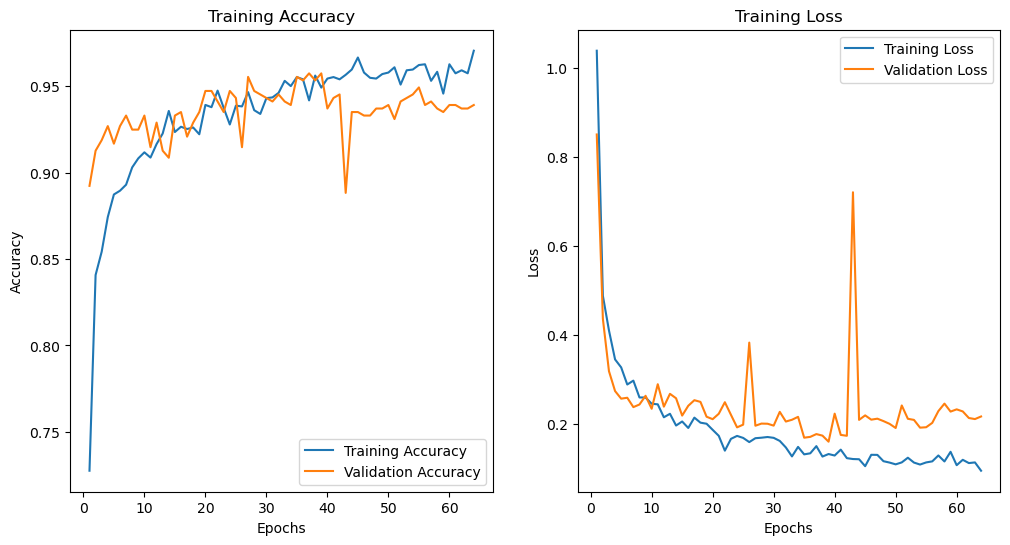

Training plots for EFFICIENTNET model:


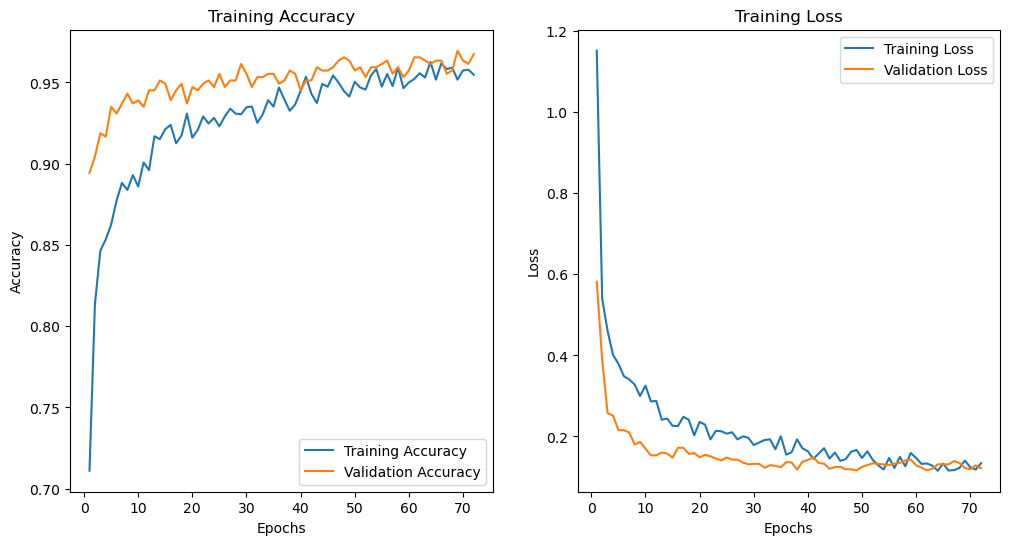

Training plots for VGGNET model:


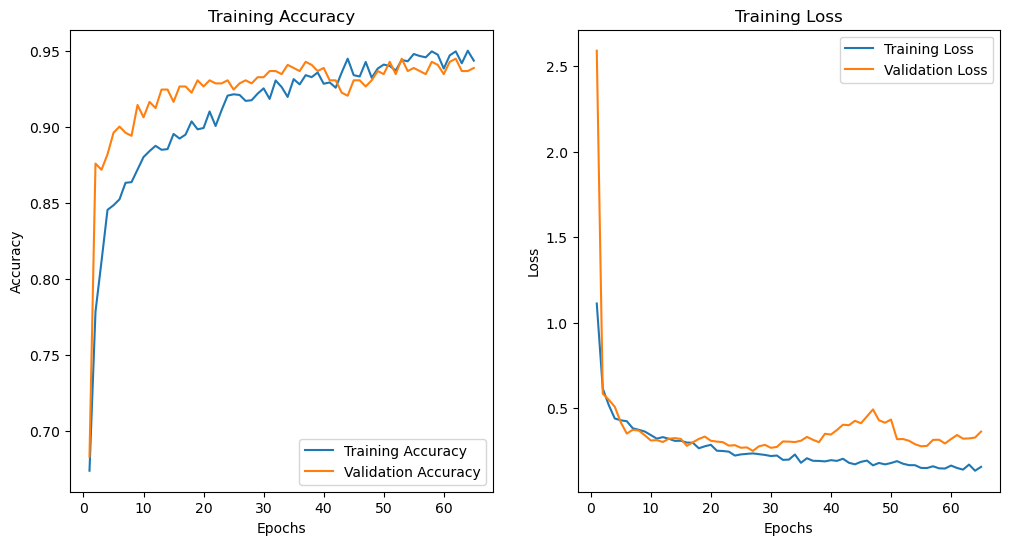

In [10]:
# Plot the training and validation accuracies / losses vs. epochs.
for base in history.keys():
    print(f"Training plots for {base} model:")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Plot the training and validation accuracy vs. epochs
    acc = history[base].history['accuracy']
    val_acc = history[base].history['val_accuracy']
    epochs = range(1, len(acc)+1)
    ax1.plot(epochs, acc, label='Training Accuracy')
    ax1.plot(epochs, val_acc, label='Validation Accuracy')
    ax1.set_title('Training Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    # Plot the training and validation loss vs. epochs
    train_loss = history[base].history['loss']
    val_loss = history[base].history['val_loss']
    ax2.plot(epochs, train_loss, label='Training Loss')
    ax2.plot(epochs, val_loss, label='Validation Loss')
    ax2.set_title('Training Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()

    plt.show()

### Report on training and test dataset

In [11]:
train_labels,train_inputs,test_labels,test_inputs = [],[],[],[]
for x, y in train_dataset:
    train_inputs.append(x)
    train_labels.append(y)
for x, y in test_dataset:
    test_inputs.append(x)
    test_labels.append(y)

train_inputs = np.concatenate(train_inputs, axis=0)
train_labels = np.concatenate(train_labels, axis=0)
test_inputs = np.concatenate(test_inputs, axis=0)
test_labels = np.concatenate(test_labels, axis=0)

for base in models.keys():
    print("*"*100)
    print(f"Training report on {base} model:")
    # predict on train set
    y_pred = models[base].predict(train_inputs)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # compute confusion matrix
    cm = confusion_matrix(train_labels, y_pred_classes)

    # print report
    print("\nConfusion Matrix: \n", cm)
    # precisions = precision_score(train_labels, y_pred_classes, average=None, zero_division=0)
    # print("\nPrecision ")
    # for i in range(len(img_classes)):
    #     print(f"{img_classes[i]}: {precisions[i]}")
    # print("Average precision: ", np.mean(precisions))
    # recalls = recall_score(train_labels, y_pred_classes, average=None, zero_division=0)
    # print("\nRecall ")
    # for i in range(len(img_classes)):
    #     print(f"{img_classes[i]}: {recalls[i]}")
    # print("Average recall: ", np.mean(recalls))
    # print("\nAccuracy: ", accuracy_score(train_labels, y_pred_classes))
    # f1_scores = f1_score(train_labels, y_pred_classes, average=None, zero_division=0)
    # print("\nF1-Scores")
    # for i in range(len(img_classes)):
    #     print(f"{img_classes[i]}: {f1_scores[i]}")
    # print("Average f1_score: ", np.mean(f1_scores))
    print("\nClassification Report: ", classification_report(train_labels, y_pred_classes, target_names=img_classes))    
    
    print(f"\nTest report on {base} model:")
    # predict on test set
    y_pred = models[base].predict(test_inputs)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # compute confusion matrix
    cm = confusion_matrix(test_labels, y_pred_classes)

    # print report
    print("\nConfusion Matrix \n", cm)
    # precisions = precision_score(test_labels, y_pred_classes, average=None, zero_division=0)
    # print("\nPrecision ")
    # for i in range(len(img_classes)):
    #     print(f"{img_classes[i]}: {precisions[i]}")
    # print("Average precision: ", np.mean(precisions))
    # recalls = recall_score(test_labels, y_pred_classes, average=None, zero_division=0)
    # print("\nRecall ")
    # for i in range(len(img_classes)):
    #     print(f"{img_classes[i]}: {recalls[i]}")
    # print("Average recall: ", np.mean(recalls))
    # print("\nAccuracy: ", accuracy_score(test_labels, y_pred_classes))
    # f1_scores = f1_score(test_labels, y_pred_classes, average=None, zero_division=0)
    # print("\nF1-Scores")
    # for i in range(len(img_classes)):
    #     print(f"{img_classes[i]}: {f1_scores[i]}")
    # print("Average f1_score: ", np.mean(f1_scores))
    print("\nClassification Report \n", classification_report(test_labels, y_pred_classes, target_names=img_classes))


****************************************************************************************************
Training report on RESNET model:
72/72 [==============================] - 15s 183ms/step

Confusion Matrix: 
 [[512   0   1   2   0]
 [  1 343   0   0   1]
 [  0   0 444   0   0]
 [  0   0   1 500   0]
 [  0   1   3   1 488]]

Classification Report:                precision    recall  f1-score   support

    baseball       1.00      0.99      1.00       515
  basketball       1.00      0.99      1.00       345
     fencing       0.99      1.00      0.99       444
      tennis       0.99      1.00      1.00       501
  volleyball       1.00      0.99      0.99       493

    accuracy                           1.00      2298
   macro avg       1.00      1.00      1.00      2298
weighted avg       1.00      1.00      1.00      2298


Test report on RESNET model:
16/16 [==============================] - 3s 230ms/step

Confusion Matrix 
 [[107   1   1   0   1]
 [  0  63   4   1   5]
 [  0   

## Video Classification Using Moving Averages

### Training on complete dataset

In [13]:
%%time
# setting epochs by observing the early stopping trend on training data
NUM_EPOCHS = 70

models = {}
history = {}

# Compile the model
optimizer = tf.keras.optimizers.legacy.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

# Retraining all models on entire dataset
for base in ['RESNET', 'EFFICIENTNET', 'VGGNET']:
    models[base] = Classification_Model(NUM_CLASSES, base=base)

    # Training on complete dataset
    models[base].compile(optimizer, loss, metrics=['accuracy'])
    # Train the model
    print(f"\nTraining {base}:")
    history[base] = models[base].fit(
        complete_dataset_augmented, 
        epochs=NUM_EPOCHS,
        batch_size=BATCH_SIZE
    )
    # saving the model
    models[base].save_weights(f'./checkpoints/{base}_model_weights_complete')
    
# Loading all models
for base in models.keys():
    models[base].load_weights(f'./checkpoints/{base}_model_weights_complete')


Training RESNET:
Epoch 1/70
52/52 [==============================] - 34s 449ms/step - loss: 0.8869 - accuracy: 0.7643
Epoch 2/70
52/52 [==============================] - 23s 434ms/step - loss: 0.4505 - accuracy: 0.8460
Epoch 3/70
52/52 [==============================] - 23s 434ms/step - loss: 0.3663 - accuracy: 0.8689
Epoch 4/70
52/52 [==============================] - 23s 436ms/step - loss: 0.3373 - accuracy: 0.8738
Epoch 5/70
52/52 [==============================] - 23s 436ms/step - loss: 0.2978 - accuracy: 0.8945
Epoch 6/70
52/52 [==============================] - 23s 436ms/step - loss: 0.2854 - accuracy: 0.8973
Epoch 7/70
52/52 [==============================] - 23s 436ms/step - loss: 0.2625 - accuracy: 0.9079
Epoch 8/70
52/52 [==============================] - 23s 433ms/step - loss: 0.2631 - accuracy: 0.9107
Epoch 9/70
52/52 [==============================] - 23s 440ms/step - loss: 0.2514 - accuracy: 0.9149
Epoch 10/70
52/52 [==============================] - 23s 436ms/step - los

### Loading video paths from Sports Video folder, creating function to get L vectors of probability predictions &
### Selecting the class with maximum probability

In [18]:
# Gather Video paths
vid_classes = ['BaseballPitch', 'Basketball', 'Fencing', 'TennisSwing', 'VolleyballSpiking']
img_to_vid_class = {'baseball':'BaseballPitch', 'basketball':'Basketball', 'fencing':'Fencing', 'tennis':'TennisSwing', 'volleyball':'VolleyballSpiking'}
vid_data = []

for c in vid_classes:
    for dir,_,files in os.walk(f"../Data/Sport Videos/{c}"):
        for file in files:
            vid_data.append([os.path.join(dir, file), c])
            
# number of frames to extract (L)
L = 100
 
def predict_video_images(path, model):
    # read video using opencv
    capture = cv2.VideoCapture(path)
    total_frames = int(capture.get(cv2.CAP_PROP_FRAME_COUNT)) - 3 # leave last few frames (can be empty)
    frames = []
    
    for i in np.linspace(0, total_frames-1, min(L, total_frames), dtype=int):
        # set the frame index to read 
        capture.set(cv2.CAP_PROP_POS_FRAMES, i)
        
        # read the current frame
        ret, frame = capture.read()
        assert(ret)

        # Convert to RGB
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        # Resize the image
        frame = cv2.resize(frame, IMG_SIZE)
        # Cast to float
        frame = tf.cast(frame, tf.float32)
        
        frames.append(frame)
    
    predictions = model.predict(np.array(frames), verbose=0)
    return img_classes[np.argmax(np.mean(np.array(predictions), axis=0), axis=0)]
    

### Report on video dataset

In [20]:

for base in models.keys():
    
    print("*"*100)
    print(f"Video classification using {base} model:")
    
    true_labels, pred_labels = [],[]
    for path, l in tqdm(shuffle(vid_data, random_state=SEED)):
        
        img_prediction = predict_video_images(path, models[base])
        true_labels.append(l)
        pred_labels.append(img_to_vid_class[img_prediction])
    
    # compute confusion matrix
    cm = confusion_matrix(true_labels, pred_labels)

    # compute classification report
    print("\nConfusion Matrix \n", cm)
    # precisions = precision_score(true_labels, pred_labels, average=None, zero_division=0, labels=vid_classes)
    # print("\nPrecision ")
    # for i in range(len(vid_classes)):
    #     print(f"{img_classes[i]}: {precisions[i]}")
    # print("Average precision: ", np.mean(precisions))
    # recalls = recall_score(true_labels, pred_labels, average=None, zero_division=0, labels=vid_classes)
    # print("\nRecall ")
    # for i in range(len(vid_classes)):
    #     print(f"{img_classes[i]}: {recalls[i]}")
    # print("Average recall: ", np.mean(recalls))
    # print("\nAccuracy: ", accuracy_score(true_labels, pred_labels))
    # f1_scores = f1_score(true_labels, pred_labels, average=None, zero_division=0, labels=vid_classes)
    # print("\nF1-Scores")
    # for i in range(len(vid_classes)):
    #     print(f"{img_classes[i]}: {f1_scores[i]}")
    # print("Average f1_score: ", np.mean(f1_scores))
    # print report
    print("\nClassification Report \n", classification_report(true_labels, pred_labels, target_names=vid_classes, labels=vid_classes, zero_division=0))

        
        

****************************************************************************************************
Video classification using RESNET model:


100%|██████████| 681/681 [10:17<00:00,  1.10it/s]



Confusion Matrix 
 [[126   0  17   6   1]
 [  2   0  65  27  43]
 [  2   0 109   0   0]
 [  1   0   5 160   1]
 [  0   0  57   0  59]]

Classification Report 
                    precision    recall  f1-score   support

    BaseballPitch       0.96      0.84      0.90       150
       Basketball       0.00      0.00      0.00       137
          Fencing       0.43      0.98      0.60       111
      TennisSwing       0.83      0.96      0.89       167
VolleyballSpiking       0.57      0.51      0.54       116

         accuracy                           0.67       681
        macro avg       0.56      0.66      0.58       681
     weighted avg       0.58      0.67      0.60       681

****************************************************************************************************
Video classification using EFFICIENTNET model:


100%|██████████| 681/681 [12:51<00:00,  1.13s/it]



Confusion Matrix 
 [[140   0   4   5   1]
 [  0   0  64  43  30]
 [  3   0 108   0   0]
 [  0   0   9 158   0]
 [  0   1  63   6  46]]

Classification Report 
                    precision    recall  f1-score   support

    BaseballPitch       0.98      0.93      0.96       150
       Basketball       0.00      0.00      0.00       137
          Fencing       0.44      0.97      0.60       111
      TennisSwing       0.75      0.95      0.83       167
VolleyballSpiking       0.60      0.40      0.48       116

         accuracy                           0.66       681
        macro avg       0.55      0.65      0.57       681
     weighted avg       0.57      0.66      0.59       681

****************************************************************************************************
Video classification using VGGNET model:


100%|██████████| 681/681 [12:24<00:00,  1.09s/it]


Confusion Matrix 
 [[125   3   3  19   0]
 [  5   1  51  68  12]
 [ 11   1  98   1   0]
 [  4   5   2 154   2]
 [  1   8  69   5  33]]

Classification Report 
                    precision    recall  f1-score   support

    BaseballPitch       0.86      0.83      0.84       150
       Basketball       0.06      0.01      0.01       137
          Fencing       0.44      0.88      0.59       111
      TennisSwing       0.62      0.92      0.74       167
VolleyballSpiking       0.70      0.28      0.40       116

         accuracy                           0.60       681
        macro avg       0.54      0.59      0.52       681
     weighted avg       0.54      0.60      0.54       681



In [7]:
vid_data = []
vid_classes = ['BaseballPitch', 'Basketball', 'Fencing', 'TennisSwing', 'VolleyballSpiking']


for c in vid_classes:
    for dir,_,files in os.walk(f"../Data/Sport Videos/{c}"):
        for file in files:
            vid_data.append([os.path.join(dir, file), c])
            
len(vid_data)

681